In [1]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial

import pysme.integrate as integ
import pysme.hierarchy as hier
from quantum_utilities.qubits import Id, zero, sigx, sigy, sigz, sigm, sigp

In [2]:
%matplotlib inline

In [3]:
def rho_from_ket(ket):
    return np.outer(ket, ket.conj())

def vac_rho(n):
    ket = np.zeros(n + 1, dtype=np.complex)
    ket[0] = 1
    return rho_from_ket(ket)

def truncated_squeezed_state(r, mu, m_max):
    ket = np.zeros(m_max + 1, dtype=np.complex)
    for n in range(m_max//2 + 1):
        ket[2*n] = (1 / np.sqrt(np.cosh(r))) * ((-0.5 * np.exp(2.j * mu) * np.tanh(r))**n /
                                                factorial(n)) * np.sqrt(factorial(2 * n))
    return ket / np.linalg.norm(ket)

def truncated_squeezed_rho(r, mu, m_max):
    ket = truncated_squeezed_state(r, mu, m_max)
    return rho_from_ket(ket)

In [4]:
def rect(x, a, b):
    return np.where(x < a, 0, np.where(x < b, 1, 0))

In [5]:
factory = hier.HierarchyIntegratorFactory(1, 6)

In [6]:
Id = np.eye(1, dtype=np.complex)
zero = np.zeros((1, 1), dtype=np.complex)

In [7]:
S = Id
L = zero
H = zero

In [8]:
integrator = factory.make_euler_jump_integrator(partial(rect, a=0, b=1),
                                                S, L, H, r=np.log(2), mu=0)

In [9]:
times = np.linspace(0, 1, 2**10)

In [10]:
soln = integrator.integrate(Id, times, return_meas_rec=True)

In [11]:
soln

(<pysme.hierarchy.HierarchySolution at 0x126b93630>,
 array([0, 0, 0, ..., 0, 0, 0]))

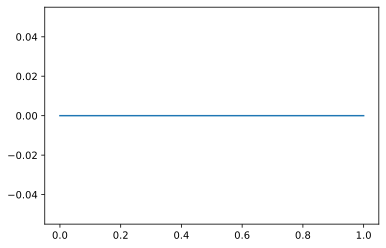

In [12]:
plt.plot(times, np.hstack([0, soln[1]]))

In [13]:
soln[1].sum()

0